# Final Project
## by Harry Zarcadoolas & Gabe De Brito

In [3]:
!where python

c:\Users\harry\anaconda3\envs\env-final-project\python.exe
C:\Program Files\Python312\python.exe
C:\Users\harry\AppData\Local\Microsoft\WindowsApps\python.exe
C:\msys64\ucrt64\bin\python.exe
C:\Users\harry\anaconda3\python.exe


#### Library Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_squared_error
from mlxtend.frequent_patterns import apriori, association_rules

In [5]:
# Load the data
data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx')

In [6]:
# Verify column names
print(data.columns)

# Initial data analysis
print()
print()
print(data.head())

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [7]:
# Address missing values
print(data.isnull().sum())
data = data.dropna(subset=['Customer ID'])
if data.isnull().sum().sum() == 0:
    print('\nNo missing values')
else:
    print('Missing values found')

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

No missing values


# Data Cleaning and Preprocessing
1. Correct column names (standardize for ease of use).
2. Handle incorrect or missing values.
3. Feature engineering (e.g., TotalPrice, time-based features).

In [8]:
# Rename columns for consistency
data.rename(columns={
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice',
    'Customer ID': 'CustomerID'
}, inplace=True)

# Create a TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Remove negative or zero quantities and prices
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Extract time-based features from InvoiceDate
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek
data['HourOfDay'] = data['InvoiceDate'].dt.hour

# Clustering: Customer Segmentation
Perform RFM analysis and cluster customers using K-Means.

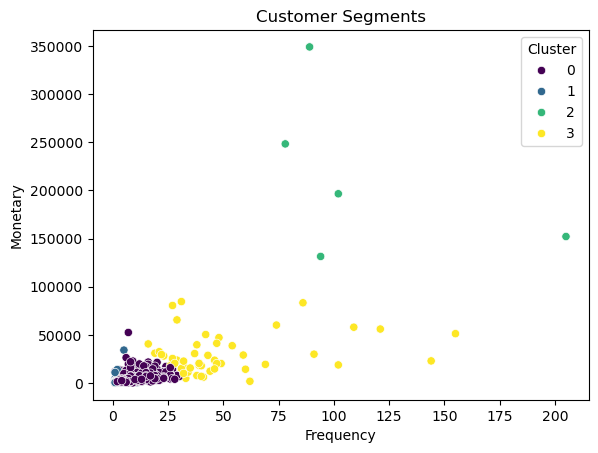

In [9]:
# RFM Analysis
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (data['InvoiceDate'].max() - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'      # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Standardize RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize the clusters
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segments')
plt.show()

# Classification: Purchase Prediction
Predict if a transaction will result in a purchase using features like time of day, quantity, and total price.

In [10]:
# Create Purchase Label
data['Purchase'] = (data['Quantity'] > 0).astype(int)

# Feature Selection
features = ['DayOfWeek', 'HourOfDay', 'Quantity', 'UnitPrice', 'TotalPrice']
X = data[features]
y = data['Purchase']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate Model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     81533

    accuracy                           1.00     81533
   macro avg       1.00      1.00      1.00     81533
weighted avg       1.00      1.00      1.00     81533



# Regression: Sales Forecasting
Forecast daily sales using time-series data.

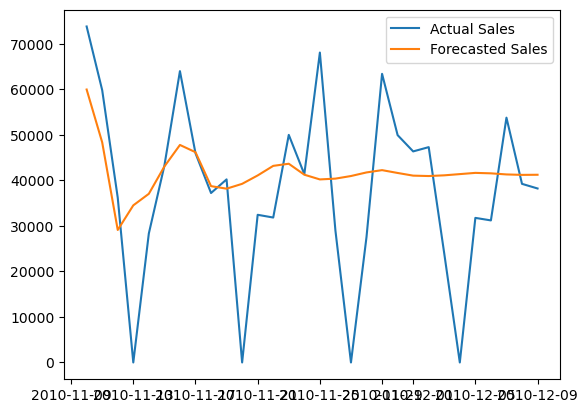

RMSE: 17748.7946318461


In [12]:
# Aggregate daily sales
daily_sales = data.set_index('InvoiceDate').resample('D')['TotalPrice'].sum()

# Split data into training and testing
train_sales = daily_sales[:-30]  # Use all but last 30 days for training
test_sales = daily_sales[-30:]   # Last 30 days for testing

# Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_sales, order=(5, 1, 0))
model_fit = model.fit()

# Forecast sales
forecast = model_fit.forecast(steps=30)
plt.plot(test_sales.index, test_sales, label='Actual Sales')
plt.plot(test_sales.index, forecast, label='Forecasted Sales')
plt.legend()
plt.show()

# Evaluate Model
rmse = np.sqrt(mean_squared_error(test_sales, forecast))
print(f'RMSE: {rmse}')

# Association Rule Mining: Product Bundling
Identify products frequently purchased together using the Apriori algorithm.

In [13]:
# Prepare basket data
basket = data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Apply Apriori Algorithm
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

# Display top rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


C:\Users\harry\AppData\Local\Temp\ipykernel_1400\840189211.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
c:\Users\harry\anaconda3\envs\env-final-project\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                        antecedents                       consequents  \
0     (60 TEATIME FAIRY CAKE CASES)  (72 SWEETHEART FAIRY CAKE CASES)   
1  (72 SWEETHEART FAIRY CAKE CASES)     (60 TEATIME FAIRY CAKE CASES)   
2     (60 TEATIME FAIRY CAKE CASES)  (PACK OF 60 DINOSAUR CAKE CASES)   
3  (PACK OF 60 DINOSAUR CAKE CASES)     (60 TEATIME FAIRY CAKE CASES)   
4     (60 TEATIME FAIRY CAKE CASES)  (PACK OF 60 MUSHROOM CAKE CASES)   

    support  confidence      lift  
0  0.018789    0.317782  8.797608  
1  0.018789    0.520173  8.797608  
2  0.018581    0.314261  9.881977  
3  0.018581    0.584288  9.881977  
4  0.010618    0.179577  7.735923  
